In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [0]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.image as mpimg
from fastai.utils.ipython import *
from fastai.metrics import *
from fastai.callbacks.tracker import SaveModelCallback

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.data
import skimage.color
from skimage.transform import rescale, resize
import scipy.misc
import scipy.signal
import time

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models
import torchvision.transforms as transforms

from matplotlib import rcParams
rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings("ignore")

In [0]:
import pickle

img_size = 32
# load from pickle file
if img_size == 32:
  train_x = pickle.load( open( "/content/gdrive/My Drive/train_x32.p", "rb" ) )
  valid_x = pickle.load( open( "/content/gdrive/My Drive/valid_x32.p", "rb" ) )
  test_x = pickle.load( open( "/content/gdrive/My Drive/test_x32.p", "rb" ) )
if img_size == 48:
  train_x = pickle.load( open( "/content/gdrive/My Drive/train_x48.p", "rb" ) )
  valid_x = pickle.load( open( "/content/gdrive/My Drive/valid_x48.p", "rb" ) )
  test_x = pickle.load( open( "/content/gdrive/My Drive/test_x48.p", "rb" ) )

train_y = pickle.load( open( "/content/gdrive/My Drive/train_y.p", "rb" ) )
valid_y = pickle.load( open( "/content/gdrive/My Drive/valid_y.p", "rb" ) )
test_y = pickle.load( open( "/content/gdrive/My Drive/test_y.p", "rb" ) )

In [0]:
print(train_x.shape)
print(valid_x.shape)

torch.Size([2592, 3, 32, 32])
torch.Size([648, 3, 32, 32])


In [0]:
assert torch.cuda.is_available()

In [0]:
RGB_train_x = train_x.cuda()
RGB_valid_x = valid_x.cuda()
test_x = test_x.cuda()

In [0]:
import torchvision

NUM_CLASSES = 2
GRAY_CHANNEL = 1
RGB_CHANNELS = 3
HEIGHT = 32
WIDTH = 32

In [0]:
def batch(batch_size, images, labels, training=True):
  """Create a batch of examples.
  
  This creates a batch of input images and a batch of corresponding
  ground-truth labels. We assume CUDA is available (with a GPU).
  
  Args:
    batch_size: An integer.
    images: images to train on
    labels: class labels of each image
    training: A boolean. If True, grab examples from the training
      set; otherwise, grab them from the validation set.
  
  Returns:
    A tuple,
    input_batch: A Variable of floats with shape
      [batch_size, 1, height, width]
    label_batch: A Variable of ints with shape
      [batch_size].
  """
  if training:
    #TODO: 3. set fixed indices to see if model will overfit as expected
    random_ind = np.random.choice(images.shape[0], size=batch_size, replace=False)
    input_batch = images[random_ind]
    label_batch = labels[random_ind]
  else:
    input_batch = images[:batch_size]
    label_batch = labels[:batch_size]
  
  input_batch = torch.tensor(input_batch, requires_grad=False, device='cuda')
  label_batch = torch.tensor(label_batch, requires_grad=False, device='cuda')
  
  return input_batch, label_batch

In [0]:
def train_step(model, train_images, train_labels, optimizer, batch_size=128):
  """Conducts one training iteration
  
  Trains on one batch of input images, computes loss, and back propagates.
  
  Args:
    model: network
    train_images: images used for training
    train_labels: class labels for each training image
    optimizer: type of optimization
    batch_size: an integer
  
  Returns:
    loss, error
  """
  model.train()

  input_batch, label_batch = batch(batch_size, train_images, train_labels, training=True)
  input_batch = input_batch.float()
  output_batch = model(input_batch)
  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()

  optimizer.zero_grad()
  loss.backward()
  
  optimizer.step()
  
  return loss.item(), error_rate.item()

In [0]:
def val(model, val_images, val_labels):
  """Conducts validation step

  Passes validation images through model, computes loss, and error rate.
  
  Args:
    model: network
    val_images: images used for validation
    val_labels: class labels for validation images
  
  Returns:
    loss, error
  """
  
  model.eval()
  input_batch, label_batch = batch(val_images.shape[0], val_images, val_labels, training=False)
  input_batch = input_batch.float()
  #TODO: 4. visualize input_batch -- what goes directly into model
  output_batch = model(input_batch)

  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  
  return loss.item(), error_rate.item()

In [0]:
def train(model, optimizer, train_images, train_labels, val_images, val_labels, num_steps, num_steps_per_val):
  """Executes entire training procedure.
  
  Iterates through each step, number of steps determined by user.
  Plots training, validation loss and training, validation error.
  
  Args:
    model: network
    optimizer: type of optimization
    train_images: images used for training
    train_labels: class labels for training images
    val_images: images used for validation
    val_labels: class labels for validation images
    num_steps: number of iterations
    num_steps_per_val: determines how often validation is done
  
  Returns:
    None
  """
  #TODO: 1. initialization
  for module in model.children():
    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
      torch.nn.init.xavier_uniform_(module.weight.data)

  info = []
  fig, ax = plt.subplots(2, 1, sharex=True)
  best_val_err = 1.0
  for step in range(num_steps):
    # TODO: 7. smaller batch size
    train_loss, train_err = train_step(model, train_images, train_labels, optimizer)
    if step % num_steps_per_val == 0:
      val_loss, val_err = val(model, val_images, val_labels)
      if val_err < best_val_err:
        best_val_err = val_err
        print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
        torch.save(model, '/content/gdrive/My Drive/bland_model' + str(img_size))
      info.append([step, train_loss, val_loss, train_err, val_err])
      print('Step {:5d}: Train Error - {:.3f}, Val Error - {:.3f}, Train Loss - {:.3f}, Val Loss - {:.3f}.'.format(step, train_err, val_err, train_loss, val_loss))
      x, y11, y12, y21, y22 = zip(*info)
      ax[0].plot(x, y11, c='r')
      ax[0].plot(x, y12, c='g')
      ax[0].legend(['Train loss', 'Val loss'])
      ax[1].plot(x, y21, c='r')
      ax[1].plot(x, y22, c='g')
      ax[1].legend(['Train err', 'Val err'])
      ax[1].set_ylim([0.0, 1.0])

In [0]:
# model definition

# inspiration: https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864
class Unit(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        
        self.conv = torch.nn.Conv2d(in_channels=in_channels,kernel_size=7,out_channels=out_channels,stride=1,padding=7//2)
        self.bn = torch.nn.BatchNorm2d(num_features=out_channels)
        self.relu = torch.nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class model1(torch.nn.Module):
  """CNN with RGB images
  
  Map from inputs with shape [batch_size, 3, 32, 32] to
  outputs with shape [batch_size, ].

  - dropout
  - batchnorm
  """
  #TODO: 6. smaller model
  #TODO: 8. add dropout
  #TODO: 9. larger model
  def __init__(self):
    # 178,178
    
    super().__init__()
    # Create 14 layers of the unit with max pooling in between
    self.unit1 = Unit(in_channels=3,out_channels=32) # 32*32*32
    self.unit2 = Unit(in_channels=32, out_channels=32) # 32*32*32
    self.unit3 = Unit(in_channels=32, out_channels=32) # 32*32*32

    self.pool1 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit4 = Unit(in_channels=32, out_channels=64) # 64*16*16
    self.unit5 = Unit(in_channels=64, out_channels=64) # 64*16*16
    self.unit6 = Unit(in_channels=64, out_channels=64) # 64*16*16
    self.unit7 = Unit(in_channels=64, out_channels=64) # 64*16*16

    self.pool2 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit8 = Unit(in_channels=64, out_channels=128) # 128*8*8
    self.unit9 = Unit(in_channels=128, out_channels=128) # 128*8*8
    self.unit10 = Unit(in_channels=128, out_channels=128) # 128*8*8
    self.unit11 = Unit(in_channels=128, out_channels=128) # 128*8*8

    self.pool3 = torch.nn.MaxPool2d(kernel_size=2)

    self.unit12 = Unit(in_channels=128, out_channels=128) # 128*4*4
    self.unit13 = Unit(in_channels=128, out_channels=128) # 128*4*4
    self.unit14 = Unit(in_channels=128, out_channels=128) # 128*4*4

    self.avgpool = torch.nn.AvgPool2d(kernel_size=4)

    self.net = torch.nn.Sequential(self.unit1, self.unit2, self.unit3,
                                   self.pool1, self.unit4, self.unit5,
                                   self.unit6, self.pool2, self.unit8,
                                   self.unit9, self.unit10, self.pool3,
                                   self.unit12, self.unit13, self.unit14,
                                   self.avgpool)  

    self.fc = torch.nn.Linear(in_features=128,out_features=NUM_CLASSES) # 2

  def forward(self, input):
    output = self.net(input)
    output = output.view(-1,128)
    output = self.fc(output)
    return output

In [1]:
# Number of neurons
print(32**3*3 + 64*16*16*4 + 128*8*8*4 + 128*4*4*3 + 2)

# Number of parameters - 49C^2


202754


Step     0: Obtained a best validation error of 0.957.
Step     0: Train Error - 0.289, Val Error - 0.957, Train Loss - 0.615, Val Loss - 0.897.
Step   100: Obtained a best validation error of 0.142.
Step   100: Train Error - 0.109, Val Error - 0.142, Train Loss - 0.232, Val Loss - 0.435.
Step   200: Obtained a best validation error of 0.111.
Step   200: Train Error - 0.070, Val Error - 0.111, Train Loss - 0.173, Val Loss - 0.343.
Step   300: Train Error - 0.078, Val Error - 0.167, Train Loss - 0.181, Val Loss - 0.598.
Step   400: Train Error - 0.039, Val Error - 0.156, Train Loss - 0.106, Val Loss - 0.534.
Step   500: Train Error - 0.055, Val Error - 0.281, Train Loss - 0.139, Val Loss - 0.614.
Step   600: Train Error - 0.016, Val Error - 0.137, Train Loss - 0.054, Val Loss - 0.339.
Step   700: Train Error - 0.023, Val Error - 0.170, Train Loss - 0.097, Val Loss - 0.462.
Step   800: Train Error - 0.070, Val Error - 0.210, Train Loss - 0.153, Val Loss - 0.617.
Step   900: Train Error -

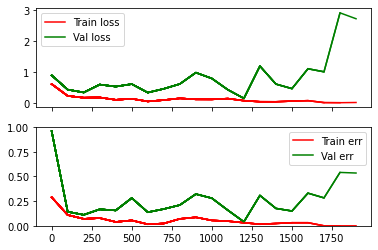

In [0]:
m = model1()
m.cuda()
#TODO: 5. play around with learning rate
optimizer1 = torch.optim.Adam(m.parameters(), lr=0.003, weight_decay=0.0000001)
train(m, optimizer1, RGB_train_x, train_y, RGB_valid_x, valid_y, 2000, 100)

In [0]:
m_loaded = torch.load("/content/gdrive/My Drive/bland_model"+str(img_size))
m_loaded.eval()

output = []
for i in range(len(test_x)):
  result = m_loaded(test_x[i:i+1,:,:,:].float())
  _, pred_batch = torch.max(result, dim=1)
  output = output + pred_batch.cpu().data.numpy().tolist()

# baseline accuracy - high 80%'s
wrong = 0
for i in range(len(output)):
  if output[i] != test_y[i]:
    wrong = wrong + 1
print(1.0 - wrong/len(output))

In [0]:
# TODO: 9. visualize first layer weights
# TODO: 10. random search for tuning multiple hyperparameters